# Multipoint heat equation

In [1]:
# dependencies
using PyPlot
using QuadGK
using ProgressMeter

## Definition of data
The initial datum is, on each subinterval $(0,\frac{1}{2})$, $(\frac{1}{2},1)$, a box centered at $q_c$, width $q_w$ and height $q_h$.

The boundary data are not yet implemented; effectively we work with homogeneous boundary conditions.

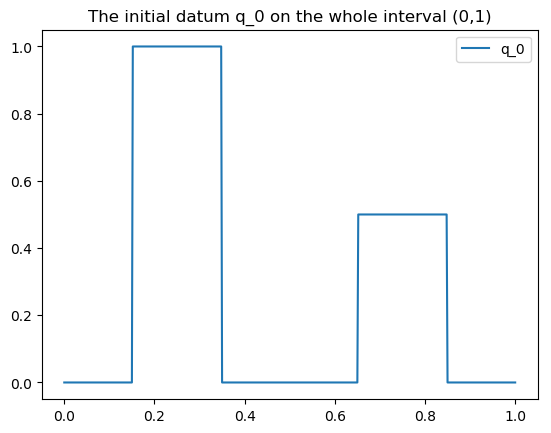

PyObject <matplotlib.legend.Legend object at 0x7f3f5c3908d0>

In [34]:
# q0 definition
(qc1,qw1,qh1)=(0.25,0.2,1)
(qc2,qw2,qh2)=(0.75,0.2,0.5)
## g0, g1 not implemented

# multipoint coefficients
(c0,c1)=(0,0)

# check the definitions are valid
if qc1-qw1/2<0 || qc2+qw2/2>1 || qc2-qw2/2<1/2 || qc1+qw1/2>1/2
    print("Check the box used to define q01 is supported on [0,1/2] and the box used to define q02 is supported on [1/2,1]")
end

function boxfunc(x,c,w,h)
    if x>c-w/2 && x<c+w/2
        return h
    else
        return 0
    end
end

Xsteps = 501;
X = linspace(0,1,Xsteps);

q0(x) = boxfunc(x,qc1,qw1,qh1)+boxfunc(x,qc2,qw2,qh2)
q0PLOT = [q0(x) for x in X];
plot(X,q0PLOT, label="q_0")

title("The initial datum q_0 on the whole interval (0,1)")
legend()

## Integrands
A common factor of $\lambda^2$ was taken out of $\Delta$, $\zeta^\pm$.

In [35]:
# integrand definition

Delta(la) = im * sin(la/2) * ( (c0+c1)/2 - cos(la/2) );

q0hat1(la) = 2*qh1/la * exp(-im*la*qc1) * sin(la*qw1/2);
q0hat2(la) = 2*qh2/la * exp(-im*la*qc2) * sin(la*qw2/2);
function q0hat(la,j)
    if j==1 return q0hat1(la) end
    q0hat2(la)
end
function q0hatfull(la,x)
    if x>1/2 return q0hat(la,2) end
    q0hat(la,1)
end

function B(la,j,k,r)
    if (r==0 && k==1) || (r==2 && k==0)
        return 0
    end
    BB = (-1)^(r+j) * exp((-1)^j * im*la*r/2) / (2*im)
    if r==1
        if k==0
            BB=BB*c0
        else
            BB=BB*c1
        end
    end
    return BB
end

function indic(j,k)
    if j==k return 0 end
    if j<k return 1 end
    -1
end

function indictriangle(l,j)
    if l>j return 0 end
    1
end

zetap(la) = sum([(B(la,0,0,j)*B(la,1,1,k)-B(la,0,1,j)*B(la,1,0,k))*q0hat(la,l)*indictriangle(l,j) for l in 1:2, k in 0:2, j in 1:2]) -
                    sum([(B(la,1,0,j)*B(la,1,1,k)-B(la,1,1,j)*B(la,1,0,k))*indic(j,k)*q0hat(-la,l)*indictriangle(l,max(j,k))*indictriangle(min(j,k)+1,l) for l in 1:2, k in 0:2, j in 0:2])/2
zetam(la) = -(sum([(B(la,0,0,j)*B(la,1,1,k)-B(la,0,1,j)*B(la,1,0,k))*q0hat(la,l)*indictriangle(j+1,l) for l in 1:2, k in 0:2, j in 0:1]) +
                    sum([(B(la,1,0,j)*B(la,1,1,k)-B(la,1,1,j)*B(la,1,0,k))*indic(j,k)*q0hat(-la,l)*indictriangle(l,max(j,k))*indictriangle(min(j,k)+1,l) for l in 1:2, k in 0:2, j in 0:2])/2)
H(la) = 0; ###NOT IMPLEMENTED

intR(la,x,t) = exp(im*la*x-la^2*t)*(q0hat1(la)+q0hat2(la));
intp(la,x,t) = exp(im*la*x-la^2*t)*( zetap(la) + H(la) ) / Delta(la);
intm(la,x,t) = exp(im*la*x-la^2*t)*( zetam(la) + H(la) ) / Delta(la);

## Zeros of $\Delta$
The zeros of $\Delta$ are displayed as points where the hue changes most rapidly in the figure below.

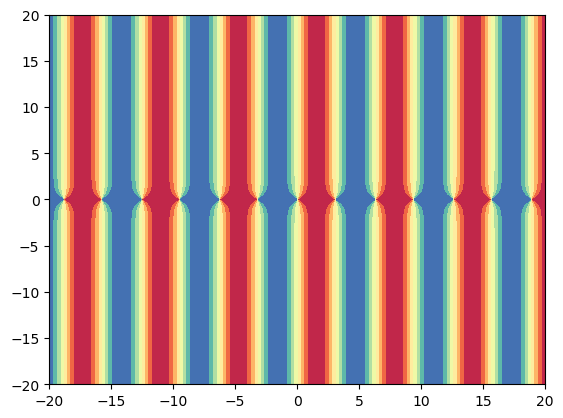

PyObject <matplotlib.contour.QuadContourSet object at 0x7f3f28b93c10>

In [36]:
# plot showing zeros of Delta
x = linspace(-20,20,1000); y = linspace(-20,20,1000);
zarg = [sin(angle(Delta(xx+im*yy))) for yy in y, xx in x];
contourf(x, y, zarg, cmap=get_cmap("Spectral"))

## Plots of the solution
This code has not been optimised to allow for large values of myinfty.
Indeed, both the numerator and denominator of $\zeta^\pm(\lambda)/\Delta(\lambda)$ grow very large with large $\lambda$ on appropriate contours, exceeding floating point maximum if `myinfty` $\gg100$.

### Choice of parameters $R$, $R_0$

If $\lvert c_0+c_1 \rvert|<2$, then these may be any positive numbers. Otherwise, care must be taken to ensure that
$$
    R>\max\{\operatorname{Im}\lambda:\Delta(\lambda)=0\}, \qquad\qquad 0<R_0<\min\{\operatorname{Im}\lambda:\Delta(\lambda)=0, \operatorname{Im}\lambda<0\}.
$$
The locus of the zeros of $\Delta$ is shown in the above plot.

In [37]:
# parameters of evaluation

myinfty=200.0; # infinite contour integrals evaluated only to this far from 0
R=5; # semi-width of horizontal strip containing all zeros of Delta. This could be calculated using lemma 2.1, or an appropriate value could be chosen using the above plot of the zeros of Delta.
R0=0.1; # the real contour is deformed this far away from 0
tol=0.0001; # absolute tolerance of integral evaluation

In [38]:
# define the contoursc
cntrR = (-myinfty,-R0,im*R0,R0,myinfty);
cntrp = (myinfty*(im-1)/sqrt(2),R*(im-1),R*(im+1),myinfty*(im+1)/sqrt(2));
cntrm = (myinfty*(-im+1)/sqrt(2),R*(-im+1),R*(-im-1),myinfty*(-im-1)/sqrt(2));

# the following redefinitions of the contours are valid iff H=0, ie iff g_0=g_1=0
cntrp = (myinfty*(im/2-1)/sqrt(2),R*(im/2-1),R*(im/2+1),myinfty*(im/2+1)/sqrt(2));
cntrm = (myinfty*(-im/2+1)/sqrt(2),R*(-im/2+1),R*(-im/2-1),myinfty*(-im/2-1)/sqrt(2));

# definition of q(x,t) as a numerical integral
q(x,t) = (
    quadgk(la -> intR(la,x,t), cntrR[1],cntrR[2],cntrR[3],cntrR[4],cntrR[5]; abstol=tol)[1]
    -
    quadgk(la -> intp(la,x,t), cntrp[1],cntrp[2],cntrp[3],cntrp[4]; abstol=tol)[1]
    -
    quadgk(la -> intm(la,x,t), cntrm[1],cntrm[2],cntrm[3],cntrm[4]; abstol=tol)[1]
    ) / (2*pi);

Computing... 79%|███████████████████████████████        |  ETA: 0:00:02

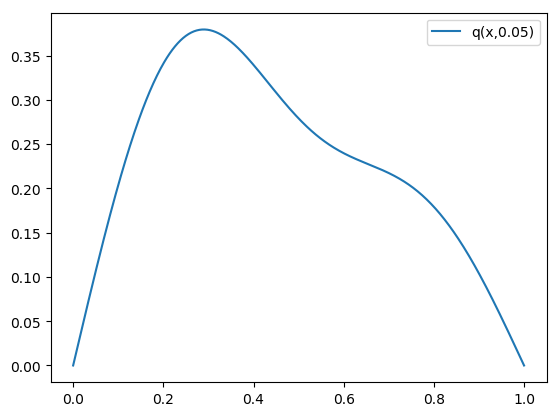

Computing...100%|███████████████████████████████████████| Time: 0:00:10


PyObject <matplotlib.legend.Legend object at 0x7f3f28dfe110>

In [39]:
# evaluate and plot
T = 0.02;
Xsteps = 501;
X = linspace(0,1.0,Xsteps);

Q = ProgressMeter.@showprogress 1 "Computing..." [q(x,T) for x in X];
# Q = [q(x,T) for x in X];
realQ = real(Q);

plot(X,realQ, label="q(x,0.05)")
#title("Contribution from integrals up to infty = "*string(myinfty)*".")
legend()

## 3d surface plots

In [40]:
# 3d surface plot

Tsteps = 501
T = linspace(0.01,1.0,Tsteps);
Xsteps = 501;
X = linspace(0.0,1.0,Xsteps);

# Q = ProgressMeter.@showprogress 1 "Computing..." [q(x,t) for x in X for t in T];



Q = ProgressMeter.@showprogress 1 "Computing..." [q(x,t) for t in T, x in X];
realQ = real(Q);

Computing...100%|███████████████████████████████████████| Time: 0:44:51


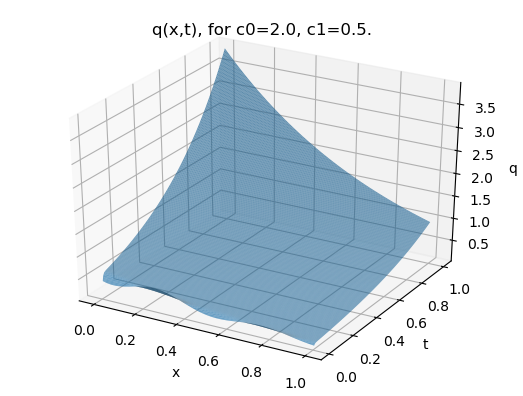

PyObject Text(0.0910982,0.0122048,u'q')

In [16]:
plot_surface(X, T, realQ, rstride=2, cstride=2, alpha=0.7, linewidth=0.25)
title("q(x,t), for c0="*string(c0)*", c1="*string(c1)*".")
xlabel("x");ylabel("t");zlabel("q");

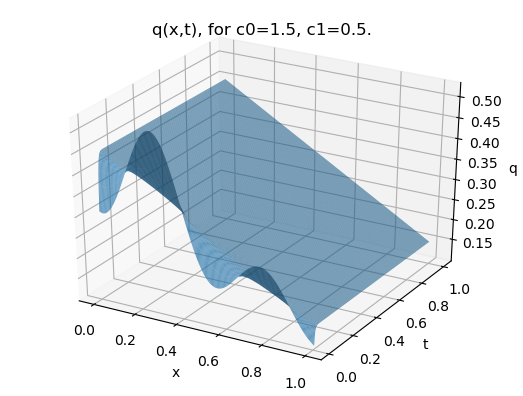

In [25]:
plot_surface(X, T, realQ, rstride=2, cstride=2, alpha=0.7, linewidth=0.25)
title("q(x,t), for c0="*string(c0)*", c1="*string(c1)*".")
xlabel("x");ylabel("t");zlabel("q");

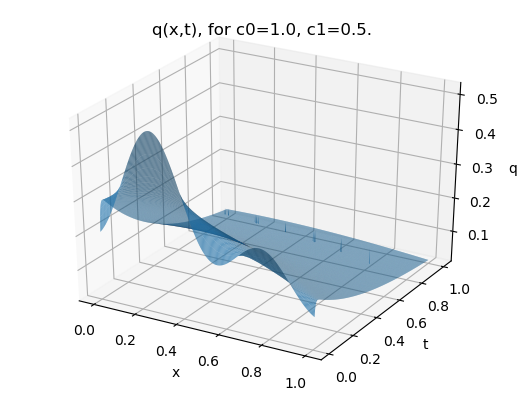

In [33]:
plot_surface(X, T, realQ, rstride=2, cstride=2, alpha=0.7, linewidth=0.25)
title("q(x,t), for c0="*string(c0)*", c1="*string(c1)*".")
xlabel("x");ylabel("t");zlabel("q");

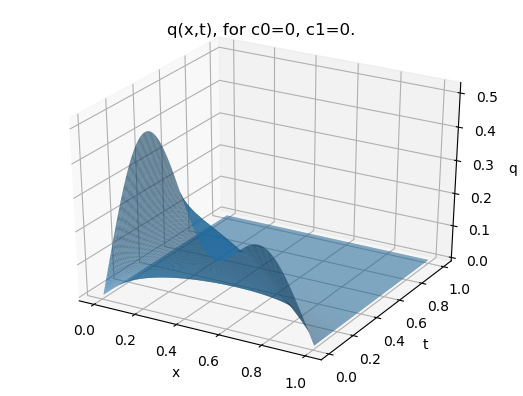

In [41]:
plot_surface(X, T, realQ, rstride=2, cstride=2, alpha=0.7, linewidth=0.25)
title("q(x,t), for c0="*string(c0)*", c1="*string(c1)*".")
xlabel("x");ylabel("t");zlabel("q");